In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [2]:
!ls

drive  sample_data


In [3]:
pwd


'/content'

In [4]:
!pip install -q keras

In [5]:
import keras
data_path = '/content/drive/My Drive/Colab Notebooks/data/New_York_Hourly.csv'

In [6]:
import pandas as pd
# df = pd.read_csv(data_path, index_col='dattim')
df = pd.read_csv(data_path)
df.head(1)

,Unnamed: 0,date,TimeEST,TemperatureF,Dew PointF,Humidity,Wind SpeedMPH,Conditions
0,0,1/1/2016,12:51 AM,42.1,25.0,51.0,4.6,Overcast


In [7]:
df.tail(1)

,Unnamed: 0,date,TimeEST,TemperatureF,Dew PointF,Humidity,Wind SpeedMPH,Conditions
5140,5140,7/1/2016,11:51 PM,75.9,60.1,58.0,3.5,Clear


In [8]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [9]:
import csv
time_step = []
temperature = []

with open( data_path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temperature.append(float(row[3]))
    time_step.append(row[0])

In [10]:
import numpy as np
series = np.array(temperature)
time = np.array(time_step)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

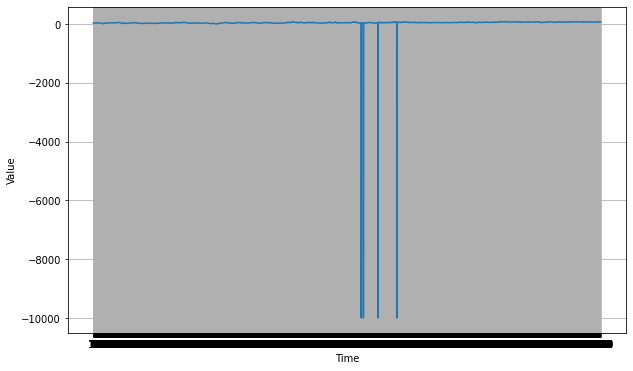

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [13]:
split_time = 4971 # xxx01Jan2012:01 - 23Nov2013:00
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:split_time + 168] # xxx23Nov2013:01 - 30Nov2013:00
x_valid = series[split_time:split_time + 168]

window_size = 168
batch_size = 100
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 168
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(286, return_sequences=True)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4971,)
Epoch 1/100
49/49 [==============================] - 25s 516ms/step - loss: 182.4670 - mae: 182.9669 - mape: 25274704.0000 - accuracy: 4.1641e-04
Epoch 2/100
49/49 [==============================] - 26s 521ms/step - loss: 82.5676 - mae: 83.0666 - mape: 20598130.0000 - accuracy: 4.1517e-04
Epoch 3/100
49/49 [==============================] - 25s 515ms/step - loss: 44.9412 - mae: 45.4375 - mape: 17122800.0000 - accuracy: 4.1641e-04
Epoch 4/100
49/49 [==============================] - 25s 514ms/step - loss: 43.6871 - mae: 44.1835 - mape: 16157924.0000 - accuracy: 4.2012e-04
Epoch 5/100
49/49 [==============================] - 26s 527ms/step - loss: 42.7482 - mae: 43.2445 - mape: 16066250.0000 - accuracy: 4.2136e-04
Epoch 6/100
49/49 [==============================] - 26s 532ms/step - loss: 41.7039 - mae: 42.2000 - mape: 16068535.0000 - accuracy: 4.1393e-04
Epoch 7/100
49/49 [=============

(1e-08, 1e-05, 0.0, 60.0)

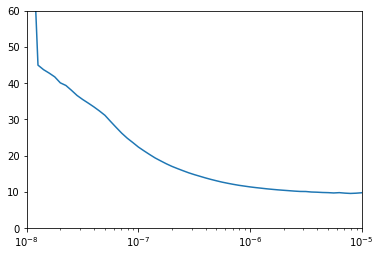

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-5, 0, 60])

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast.shape

(4974, 168, 1)

In [19]:
rnn_forecastx = rnn_forecast[split_time - window_size:split_time, -1, 0]

In [20]:
rnn_forecastx.shape

(168,)

In [21]:
split_time

4971

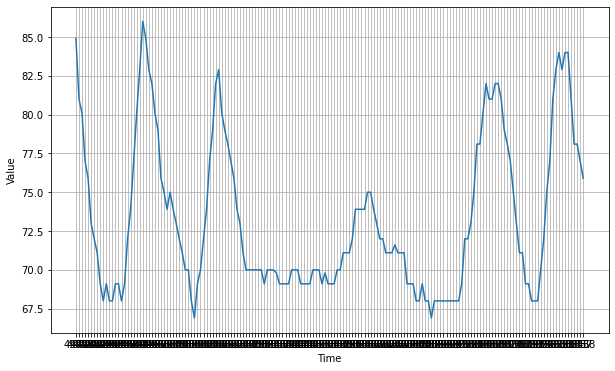

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx).numpy()

nan

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=672, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(286, return_sequences=True)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
43/43 [==============================] - 95s 2s/step - loss: 53.0920 - mae: 53.5886 - mape: 13789631.0000 - accuracy: 4.5969e-04
Epoch 2/50
43/43 [==============================] - 94s 2s/step - loss: 21.8796 - mae: 22.3699 - mape: 6456643.5000 - accuracy: 4.6003e-04
Epoch 3/50
43/43 [==============================] - 93s 2s/step - loss: 17.5994 - mae: 18.0840 - mape: 5310453.5000 - accuracy: 4.4826e-04
Epoch 4/50
43/43 [==============================] - 95s 2s/step - loss: 16.2870 - mae: 16.7688 - mape: 4840303.5000 - accuracy: 4.3788e-04
Epoch 5/50
43/43 [==============================] - 95s 2s/step - loss: 15.2289 - mae: 15.7064 - mape: 4023431.2500 - accuracy: 4.1226e-04
Epoch 6/50
43/43 [==============================] - 93s 2s/step - loss: 14.4171 - mae: 14.8902 - mape: 3728816.0000 - accuracy: 3.7349e-04
Epoch 7/50
43/43 [==============================] - 94s 2s/step - loss: 13.8473 - mae: 14.3167 - mape: 3675207.0000 - accuracy: 3.3923e-04
Epoch 8/50
43/43 [========

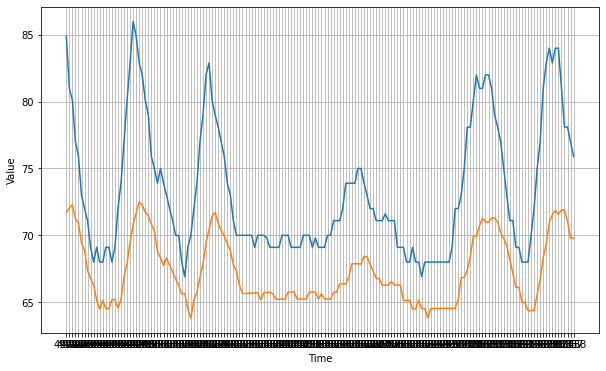

In [25]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecastx2 = rnn_forecast2[split_time - window_size-1:split_time-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx2)


In [26]:
rnn_forecastx2.shape

(168,)

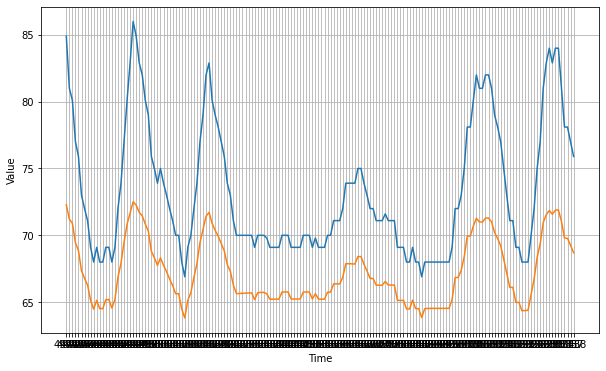

In [27]:
#rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecastx2 = rnn_forecast2[split_time - window_size+1:split_time+1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx2)


In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx2).numpy()

5.970173